# Star Wars dice rolling simulator
Original question posed as, 

    Part 1) "In a game, you start with 3 dice with 8 sides (d8),
    When you upgrade, is it better change a d8 to a d12, or instead add a d6?"
    
    Part 2) Add in an additional mechanic for each dice, and see how we can optimize between for both outcomes
    
This depends on the content of each of the sides, and what fovorable or unfavorable outcomes you are optimizing for.
Below we will be solving with a brute force method, then with pure math

# Setup

### Load packages

In [1]:
# First import librarires
# numpy will be used for our random number generator, and for quickly bucketing the histogram
# matplotlib is for plotting the histogram

import numpy as np
import math
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

### Problem Definitions

In [2]:
# Setup a default random number generator from numpy
# since no seed is specified, a random seed will be pulled fresh from the OS
rng = np.random.default_rng()

d6_dice = {
    1: { "success": 0, "advantage": 0 },
    2: { "success": 0, "advantage": 0 },
    3: { "success": 1, "advantage": 0 },
    4: { "success": 0, "advantage": 1 },
    5: { "success": 0, "advantage": 2 },
    6: { "success": 1, "advantage": 1 }
}

d8_dice = {
    1: { "success": 0, "advantage": 0 },
    2: { "success": 1, "advantage": 0 },
    3: { "success": 1, "advantage": 0 },
    4: { "success": 0, "advantage": 1 },
    5: { "success": 0, "advantage": 1 },
    6: { "success": 1, "advantage": 1 },
    7: { "success": 0, "advantage": 2 },
    8: { "success": 2, "advantage": 0 }
}

d12_dice = {
    1: { "success": 0, "advantage": 0 },
    2: { "success": 1, "advantage": 1, "crit": True},
    3: { "success": 1, "advantage": 0 },
    4: { "success": 1, "advantage": 0 },
    5: { "success": 0, "advantage": 1 },
    6: { "success": 1, "advantage": 1 },
    7: { "success": 1, "advantage": 1 },
    8: { "success": 1, "advantage": 1 },
    9: { "success": 2, "advantage": 0 },
    10: { "success": 2, "advantage": 0 },
    11: { "success": 0, "advantage": 2 },
    12: { "success": 0, "advantage": 2 }
}

dice_chooser = {
    6: d6_dice,
    8: d8_dice,
    12: d12_dice
}

# Brute Force: Monte Carlo

In [3]:
# Helper to roll the dice
# input is: [ [number of dice type 1, number of sides of dice type 1], [..2, ..2], ... ]
# output is: 

def roll_dice(dice_specs):
    result = {
        'throws': [],
        't_score': 0,
        's_score': 0,
        'a_score': 0,
        'profile': {
            'success': 0,
            'advantage': 0,
            'crit': 0
        } 
    }
    
    for i in range(len(dice_specs)):
        n_sides = dice_specs[i][1]
        n_dice = dice_specs[i][0]
        rolls = rng.integers(low = 1, high=n_sides, size=n_dice, endpoint=True)
        
        d_dict = dice_chooser[n_sides] if n_sides in dice_chooser.keys() else print("Error, dice not found")
        
        for roll in rolls:
            outcome = d_dict[roll]
            success = outcome['success']
            advantage = outcome['advantage']
            result['profile']['success'] += success
            result['profile']['advantage'] += advantage
            if 'crit' in outcome.keys(): result['profile']['crit'] += 1
            result['throws'].append(outcome)
            result['s_score'] += success
            result['a_score'] += advantage
            result['t_score'] += success + advantage
    
    flat_profile = [result['profile']['success'], result['profile']['advantage'], result['profile']['crit']]
    result['flat_profile'] = str(result['t_score']) + " " + str(flat_profile)
    
    return result

In [4]:
# Let's try it out. 
# Let's roll 3d8 and 1d6
result = roll_dice([[3,8], [1,6]])
print(json.dumps(result, indent=2))


{
  "throws": [
    {
      "success": 0,
      "advantage": 1
    },
    {
      "success": 0,
      "advantage": 2
    },
    {
      "success": 2,
      "advantage": 0
    },
    {
      "success": 0,
      "advantage": 0
    }
  ],
  "t_score": 5,
  "s_score": 2,
  "a_score": 3,
  "profile": {
    "success": 2,
    "advantage": 3,
    "crit": 0
  },
  "flat_profile": "5 [2, 3, 0]"
}


In [5]:
# now let's
# 1. collect a bunch of samples,
# 2. bin the results into a histogram
# 3. organize histogram by desireable outcome

def roll_stats_descriptive( dice_specs, n_rolls = 10000):
    histo = {}
    for i in range(n_rolls):
        results = roll_dice(dice_specs)
        if results['flat_profile'] in histo.keys():
            histo[results['flat_profile']] +=1
        else:
            histo[results['flat_profile']] = 1
            
    return histo

In [6]:
histo = roll_stats_descriptive( [[1, 8], [1, 12]])
print(json.dumps(histo, indent=2, sort_keys=True))
# Note, this will get us into trouble if we ever have a score 10 or more,
#  as the sort is sorting on the string representation of the score

{
  "0 [0, 0, 0]": 127,
  "1 [0, 1, 0]": 312,
  "1 [1, 0, 0]": 422,
  "2 [0, 2, 0]": 493,
  "2 [1, 1, 0]": 1033,
  "2 [1, 1, 1]": 96,
  "2 [2, 0, 0]": 719,
  "3 [0, 3, 0]": 535,
  "3 [1, 2, 0]": 1312,
  "3 [1, 2, 1]": 199,
  "3 [2, 1, 0]": 1358,
  "3 [2, 1, 1]": 219,
  "3 [3, 0, 0]": 653,
  "4 [0, 4, 0]": 203,
  "4 [1, 3, 0]": 516,
  "4 [1, 3, 1]": 95,
  "4 [2, 2, 0]": 742,
  "4 [2, 2, 1]": 99,
  "4 [3, 1, 0]": 513,
  "4 [3, 1, 1]": 116,
  "4 [4, 0, 0]": 238
}


In [20]:
# Now let's add up probability of each score

def roll_stats( dice_specs, n_rolls = 10000, normalize=True):
    s_histo = {}
    a_histo = {}
    t_histo = {}
    for i in range(n_rolls):
        results = roll_dice(dice_specs)
        s_histo[results['s_score']] = 1 if results['s_score'] not in s_histo else s_histo[results['s_score']] + 1
        a_histo[results['a_score']] = 1 if results['a_score'] not in a_histo else a_histo[results['a_score']] + 1
        t_histo[results['t_score']] = 1 if results['t_score'] not in t_histo else t_histo[results['t_score']] + 1
    
    histograms = []
    for histo in [s_histo, a_histo, t_histo]:
        # possibilites - answers which we have found
        poss = [ int(i) for i in histo.keys() ]
        labels = np.arange(min(poss), max(poss)+1)
        values = np.zeros(len(labels), dtype = int)
        for i in histo.keys():
            values[int(i)-min(poss)] = histo[i]
        if normalize:
            values_nl = [ i/sum(values) for i in values ]
            values = values_nl
        histograms.append( [labels, values] )
        
    return histograms

In [27]:
n_rolls = 50000
histos = roll_stats( [[3, 8], [1, 6]], n_rolls, normalize=True)
print(histos[0][1])

[0.08516, 0.22756, 0.29918, 0.22942, 0.1144, 0.03644, 0.00744, 0.0004]


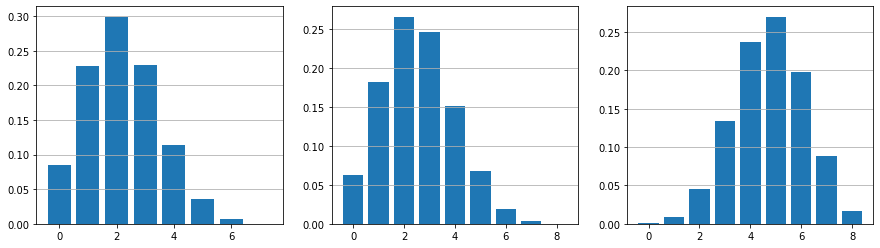

In [28]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))
for i in range(3):
    axs[i].bar(histos[i][0], histos[i][1])
    axs[i].yaxis.grid()
plt.show()

In [10]:
def gather_points(labels, values, n_rolls):
    sum_rolls = []
    min_label = min(labels)
    for i in labels:
        sum_rolls.append(i * values[i-min_label] * n_rolls)
    
    total = sum(sum_rolls)
    return sum_rolls, total

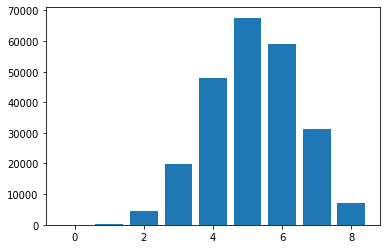

237506.0


In [11]:
labels, values = histos[2]
points, total = gather_points(labels,values, n_rolls)
plt.bar(labels, points)
plt.show()
print(total)

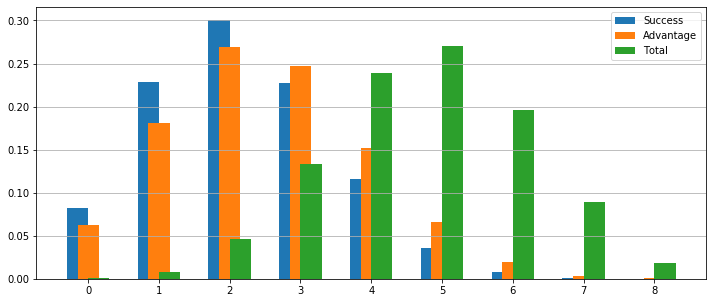

In [12]:
# Let's play with grouped bar charts

fig, ax = plt.subplots(figsize=(12,5))
width = 0.3
successes = ax.bar(histos[0][0] - width/2, histos[0][1], width, label = "Success")
advantage = ax.bar(histos[1][0] + 0    , histos[1][1], width, label = "Advantage")
total =     ax.bar(histos[2][0] + width/2, histos[2][1], width, label = "Total")

ax.set_xticks(range(9))
ax.yaxis.grid()
ax.legend()
plt.show()

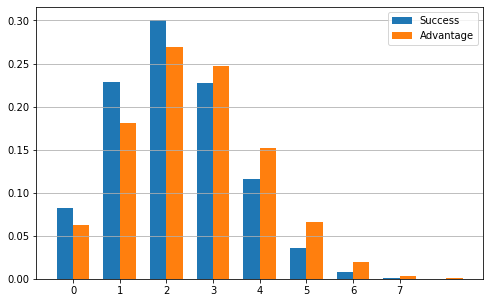

In [13]:
# This is a little cramped and hard to read. Let's just do success and advantage

fig, ax = plt.subplots(figsize=(8,5))
width = 0.35
successes = ax.bar(histos[0][0] - width/2, histos[0][1], width, label = "Success")
advantage = ax.bar(histos[1][0] + width/2, histos[1][1], width, label = "Advantage")

ax.set_xticks(range(8))
ax.yaxis.grid()
ax.legend()
plt.show()

In [14]:
# This is still not optimal
# Let's try adding an 'At Least' graph
def calc_at_least(values):
    reverse_sum = [values[-1]]
    for i in reversed(values[:-1]):
        reverse_sum.append(i + reverse_sum[-1])

    reverse_sum.reverse()
    return reverse_sum

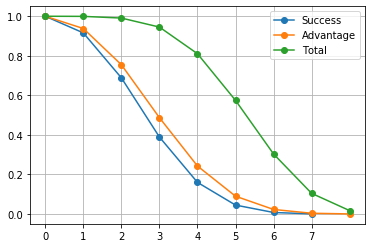

In [45]:
n_rolls = 50000
histos = roll_stats( [[3, 8], [1, 6]], n_rolls)

fig, ax = plt.subplots()
r_suc = calc_at_least(histos[0][1])
r_adv = calc_at_least(histos[1][1])
r_tot = calc_at_least(histos[2][1])

success = ax.plot(histos[0][0], r_suc, label = "Success", marker='o')
advantage = ax.plot(histos[1][0], r_adv, label = "Advantage", marker='o')
total = ax.plot(histos[2][0], r_tot, label = "Total", marker='o')

ax.set_xticks(range(8))
ax.grid()
ax.legend()
plt.show()

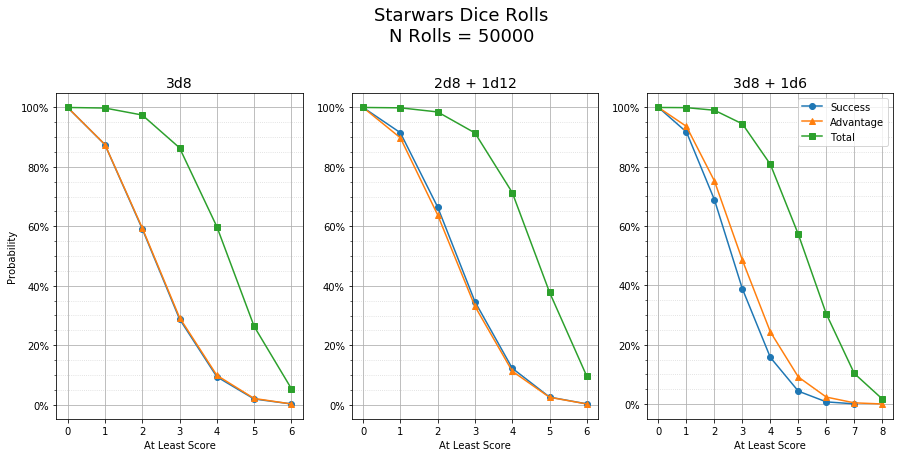

In [65]:
# Let's plot the three possibilties at once


n_rolls = 50000

rolls = {
    '3d8': [[3,8]],
    '2d8 + 1d12': [[2,8],[1,12]],
    '3d8 + 1d6': [[3,8],[1,6]],
}

fig, axs = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle("Starwars Dice Rolls\nN Rolls = "+ str(n_rolls), fontsize=18, y=1.08)
#fig.subplots_adjust(hspace=.6)

### 3d8 ###
i = 0
for roll in rolls.keys():
    histos = roll_stats(rolls[roll], n_rolls)
    r_suc = calc_at_least(histos[0][1])
    r_adv = calc_at_least(histos[1][1])
    r_tot = calc_at_least(histos[2][1])

    axs[i].plot(histos[0][0], r_suc, label="Success", marker='o')
    axs[i].plot(histos[1][0], r_adv, label="Advantage", marker='^')
    axs[i].plot(histos[2][0], r_tot, label="Total", marker='s')
    axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
    axs[i].set_yticks(np.arange(0,1,.05), minor=True)
    axs[i].set_xticks(range(max(histos[2][0])+1))
    axs[i].grid(which='both')
    axs[i].grid(which='minor', alpha=0.5, linestyle=':')
    axs[i].set_title(roll, fontdict={'fontsize':14})
    axs[i].set_xlabel("At Least Score")
    if i == 0:
        axs[i].set_ylabel("Probability")
    
    i+=1
    
plt.legend()
plt.show()

In [16]:
# Looking good. Now let's do a similar thing for cumulative scores
def calc_cum_score(labels, values, n_rolls, normalize=False):
    sum_score = 0
    for i in labels:
        sum_score += i * values[i] * n_rolls
    
    if normalize:
        sum_score = sum_score / n_rolls
        
    return sum_score

In [17]:
# Beef up labeling
def autolabel_smalls(ax, rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ypos = rect.get_height() + rect.get_y()
        ax.annotate('{}'.format(height)[:4],
                    xy=(rect.get_x() + rect.get_width() / 2, ypos),
                    xytext=(0, -15),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color="white")
        
def autolabel_big(ax, rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ypos = rect.get_height() + rect.get_y()
        ax.annotate(str(ypos)[:4],
                    xy=(rect.get_x() + rect.get_width() / 2, ypos),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

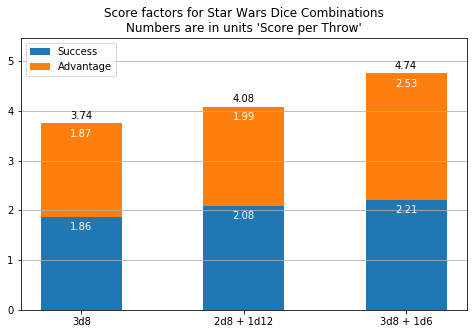

In [31]:
n_rolls = 50000
normalize = True

fig, ax = plt.subplots(figsize=(8,5))

s_score = []
a_score = []

histos = roll_stats( [[3, 8]], n_rolls)
s_score.append( calc_cum_score(histos[0][0], histos[0][1], n_rolls, normalize) )
a_score.append( calc_cum_score(histos[1][0], histos[1][1], n_rolls, normalize) )

histos = roll_stats( [[2, 8], [1,12]], n_rolls)
s_score.append( calc_cum_score(histos[0][0], histos[0][1], n_rolls, normalize) )
a_score.append( calc_cum_score(histos[1][0], histos[1][1], n_rolls, normalize) )

histos = roll_stats( [[3, 8], [1,6]], n_rolls)
s_score.append( calc_cum_score(histos[0][0], histos[0][1], n_rolls, normalize) )
a_score.append( calc_cum_score(histos[1][0], histos[1][1], n_rolls, normalize) )

t_score = [ s + a for s, a, in zip(s_score, a_score) ]


index = [1,2,3]

width = .5
p1 = ax.bar(index, s_score, width, label = "Success")
p2 = ax.bar(index, a_score, width, bottom=s_score, label = "Advantage")

plt.xticks(index, ("3d8", "2d8 + 1d12", "3d8 + 1d6"))
ax.yaxis.grid()
plt.legend()
autolabel_smalls(ax, p1)
autolabel_smalls(ax, p2)
autolabel_big(ax,p2)
ax.set_ylim(ymax = max(t_score) * 1.15 )
plt.title("Score factors for Star Wars Dice Combinations\nNumbers are in units \'Score per Throw\'")

plt.show()